In [ ]:
# 対象月を制限する
#　秋入りは9月以降、冬入りは10月以降

In [1]:
%load_ext autoreload
%autoreload 2

from meteo_lib import PROJECT  # または: from meteo_lib.paths import PROJECT
#out_dir  = PROJECT / "outputs"

from meteo_lib.meteo_lib import getBlock, get_HourlyData, get_10minData
from meteo_lib.my_path_utils import DATA, OUT

import pandas as pd
import math
import numpy as np
from datetime import datetime, timedelta, date, time
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.family"] = "Hiragino Sans"   # 例：Noto Sans CJK JP でも可
mpl.rcParams["axes.unicode_minus"] = False    # －が豆腐になるのを回避

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter, MultipleLocator
import os
from pathlib import Path
import calendar
from IPython.display import display 

In [9]:
# 移動平均：5日　　持続窓：7日　　多数決：5/7　　快適帯：18℃ ≤ AT ≤ 24℃　　
# 秋入り：24℃以下  秋明け：18℃未満

import pandas as pd
import numpy as np

def _find_event_by_majority(flag: pd.Series, window: int, majority: int):
    """
    flag: bool Series（indexはDatetimeIndex、日次で連続が望ましい）
    window日間のうち majority日以上 True なら成立。
    成立したら、その成立窓の中で最初にTrueになった日を返す。
    """
    flag = flag.astype(bool)
    if len(flag) < window:
        return None

    roll = flag.astype(int).rolling(window, min_periods=window).sum()
    hit = roll >= majority
    if not hit.any():
        return None

    d_star = hit.idxmax()  # 最初に成立した日（右端日）
    win = flag.loc[d_star - pd.Timedelta(days=window-1) : d_star]
    idx = win.index[win.to_numpy()]
    return idx[0] if len(idx) else None


def find_autumn_period_month_limited_multi(
    csv_path,
    cols=("AT", "AT_daily", "temp", "temp_daily"),
    date_col="日時",
    ma_days=5,
    window=7,
    majority=5,
    th_hi=24.0,
    th_lo=18.0,
    # 探索する月の範囲
    start_month_hi=7,   # 秋入り探索開始月
    end_month_hi=12,    # 秋入り探索終了月
    start_month_lo=8,   # 秋明け探索開始月（秋入り後にさらに絞る）
    end_month_lo=2,     # 秋明け探索終了月（翌年2月まで許す、など）
    # 出力形式
    return_wide=True,
):
    """
    4系列など複数列をループで秋入り/秋明けを算出。
    - MAはright（center=False）
    - 日次に連続化して窓（7日）が暦通りに効くようにする
    """
    df0 = pd.read_csv(csv_path, parse_dates=[date_col]).set_index(date_col).sort_index()

    # 日次連続化（欠測があっても窓が「7日」のままになる）
    full_index = pd.date_range(df0.index.min(), df0.index.max(), freq="D")
    df0 = df0.reindex(full_index)

    years = sorted(pd.Index(full_index.year).unique())
    rows = []

    for col in cols:
        if col not in df0.columns:
            raise KeyError(f"column '{col}' not found in CSV")

        s = df0[col].astype(float)
        ma = s.rolling(ma_days, min_periods=ma_days).mean()  # 5日移動平均（right）
        cool = (ma <= th_hi).fillna(False)
        cold = (ma < th_lo).fillna(False)

        for y in years:
            # 秋入り探索（年内、月で絞る）
            start_hi = pd.Timestamp(y, start_month_hi, 1)
            end_hi   = (pd.Timestamp(y, end_month_hi, 1) + pd.offsets.MonthEnd(0))

            cool_y = cool.loc[start_hi:end_hi]
            autumn_start = _find_event_by_majority(cool_y, window, majority)

            if autumn_start is None:
                rows.append({
                    "year": y, "series": col,
                    "autumn_start": pd.NaT, "autumn_end": pd.NaT, "length_days": np.nan
                })
                continue

            # 秋明け探索（秋入り以降〜 end_month_lo 末まで。年またぎ対応）
            # end_month_lo が start_month_lo より小さい場合は翌年まで
            y_end = y + (1 if end_month_lo < start_month_lo else 0)
            span_end = (pd.Timestamp(y_end, end_month_lo, 1) + pd.offsets.MonthEnd(0))

            cold_span = cold.loc[autumn_start:span_end]

            # 月の絞り（年またぎ考慮）
            if end_month_lo >= start_month_lo:
                mask_lo = (cold_span.index.month >= start_month_lo) & (cold_span.index.month <= end_month_lo)
            else:
                mask_lo = (cold_span.index.month >= start_month_lo) | (cold_span.index.month <= end_month_lo)

            cold_span = cold_span[mask_lo]
            autumn_end = _find_event_by_majority(cold_span, window, majority)

            length = (autumn_end - autumn_start).days + 1 if pd.notna(autumn_end) else np.nan

            rows.append({
                "year": y, "series": col,
                "autumn_start": autumn_start, "autumn_end": autumn_end, "length_days": length
            })

    out_long = pd.DataFrame(rows).sort_values(["series", "year"]).reset_index(drop=True)

    if not return_wide:
        return out_long

    out_wide = (out_long.pivot(index="year", columns="series",
                              values=["autumn_start", "autumn_end", "length_days"])
                        .sort_index())
    return out_long, out_wide


In [19]:
csv_path = DATA / "AT_仙台_1970-2024.csv"

out_long, out_wide = find_autumn_period_month_limited_multi(
    csv_path,
    cols=("AT", "AT_daily", "temp", "temp_daily"),
    ma_days=5, window=7, majority=5,
    start_month_hi=9, end_month_hi=12,  # 秋入り探索
    start_month_lo=10, end_month_lo=2,   # 秋明け探索（翌年2月まで）
)
#display(out_long.head)
display(out_wide.head())

out_path = OUT /  "体感温度_仙台_月縛り.csv"
out_wide.to_csv(out_path)


autumn_start                                  autumn_end             \
series           AT   AT_daily       temp temp_daily         AT   AT_daily   
year                                                                         
1970     1970-09-07 1970-09-15 1970-09-01 1970-09-07 1970-10-01 1970-10-01   
1971     1971-09-01 1971-09-01 1971-09-01 1971-09-01 1971-10-01 1971-10-01   
1972     1972-09-02 1972-09-11 1972-09-01 1972-09-01 1972-10-01 1972-10-01   
1973     1973-09-06 1973-09-07 1973-09-05 1973-09-07 1973-10-05 1973-10-06   
1974     1974-09-08 1974-09-09 1974-09-01 1974-09-01 1974-10-02 1974-10-05   

                             length_days                           
series       temp temp_daily          AT AT_daily temp temp_daily  
year                                                               
1970   1970-10-01 1970-10-01          25       17   31         25  
1971   1971-10-01 1971-10-01          31       31   31         31  
1972   1972-10-01 1972-10-13          30       21   31         43  
1973   1973-10-05 1973-10-06          30       30   31         30  
1974   1974-10-02 1974-10-08          25       27   32         38

In [15]:
df_A = out_wide.xs("autumn_start", level=0, axis=1)
df_A.head()

series,AT,AT_daily,temp,temp_daily
year,,,,
1970,1970-09-07,1970-09-15,1970-09-01,1970-09-07
1971,1971-09-01,1971-09-01,1971-09-01,1971-09-01
1972,1972-09-02,1972-09-11,1972-09-01,1972-09-01
1973,1973-09-06,1973-09-07,1973-09-05,1973-09-07
1974,1974-09-08,1974-09-09,1974-09-01,1974-09-01


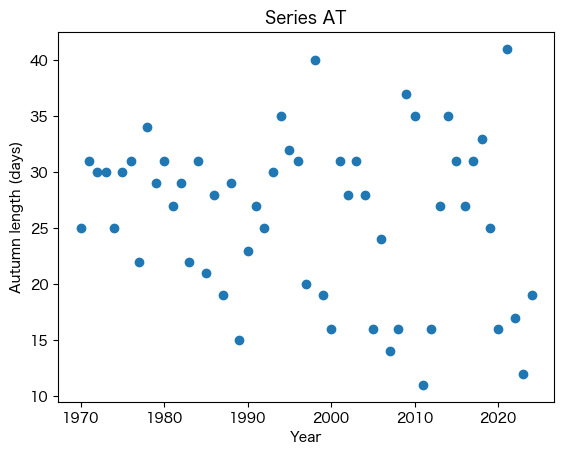

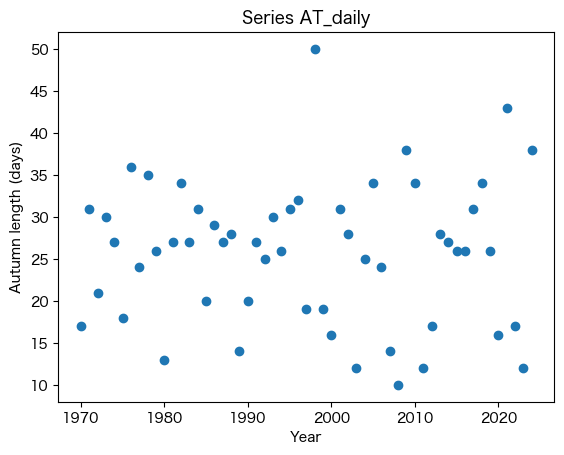

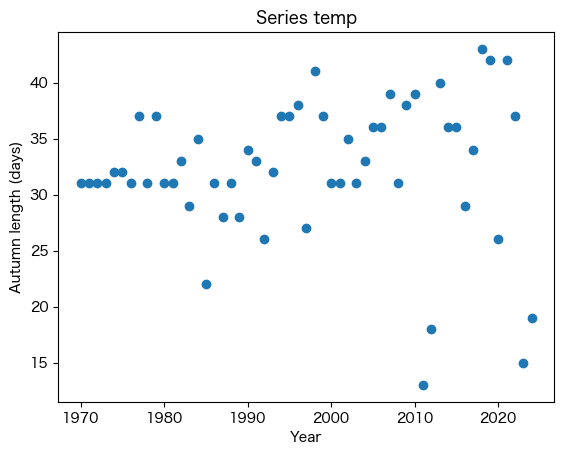

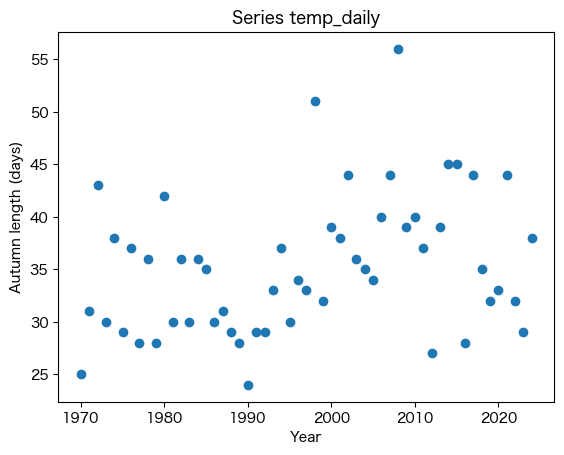

In [16]:
#fig, ax1 = plt.subplots(figsize=(10, 5))
for s in out_wide.columns.levels[1]:
    df_s = out_wide.xs(s, level="series", axis=1)
    fig, ax = plt.subplots()
    ax.plot(df_s.index, df_s["length_days"], linestyle="", marker="o")
    ax.set_title(f"Series {s}")
    ax.set_ylabel("Autumn length (days)")
    ax.set_xlabel("Year")
plt.show()

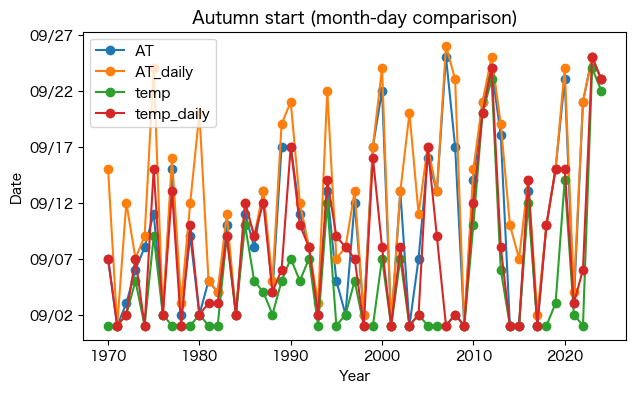

In [18]:
df = out_wide.xs("autumn_start", level=0, axis=1)
#index : year (1970, 1971, ...)
#columns : series (AT, AT_daily, temp, temp_daily)
#values : datetime64[ns]

df_doy = df.apply(lambda s: s.dt.dayofyear)    # datetime=>DOY(day of year)
fig, ax = plt.subplots(figsize=(7, 4))

for col in df_doy.columns:
    ax.plot(df_doy.index, df_doy[col], marker="o", label=col)

ax.set_xlabel("Year")
ax.set_ylabel("Date")
ax.set_title("Autumn start (month-day comparison)")
ax.legend()

import matplotlib.dates as mdates
from datetime import datetime

def doy_to_mmdd(doy):
    return datetime(2001, 1, 1) + pd.to_timedelta(doy - 1, unit="D")

ax.yaxis.set_major_formatter(
    lambda x, pos: doy_to_mmdd(int(x)).strftime("%m/%d")
)

plt.show()